In [12]:
'''
You can make use of any of these libraries to help you in your code.
'''
from google.colab import files
from io import BytesIO
from PIL import Image
import cv2
import numpy as np
import scipy
from scipy import signal

# If you get an error regarding the release version of albumentations, Ignore it.

# New Section

Upload images and npy files

In [13]:
''' 
Run this cell and click on the "Choose Files" option and select the two input 
input images 'orange.png and 'apple.png' from your local machine to upload it
to the current session of Google Colab. Enable third party cookies in your 
browser if you encounter any problems while uploading the images.
'''

# Import Images
uploaded = files.upload()
orange = Image.open(BytesIO(uploaded['orange.png']))
apple = Image.open(BytesIO(uploaded['apple.png']))

# Input Image as Numpy Arrays
orange = np.array(orange)
apple = np.array(apple)

Saving apple.png to apple (1).png
Saving orange.png to orange (1).png


helper function to generate Gaussian Kernel

In [14]:
'''
This function is provided to you to use in your solution. You should not modify 
this function. 
'''

def get_gaussian_kernel(size, sigma):
  """
  This function returns a gaussian kernel given size and sigma

  size - number of rows/ no. of cols 
  sigma - standard deviation of the gaussian kernel required
  returns size * size 
  """
  # DO NOT MODIFY
  kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
  kernel /= np.sum(kernel)
  
  return kernel

Part 1: expand and reduce image


In [15]:
def expand(input_image):
  """
  This function returns The image after the expand operation

  Input: 
    input_image: (m x n x 1)/(m x n x 3)  - The input image (numpy array)

  Output-
    output - (2m x 2n x 1)/(2m x 2n x 3)  - The output image (numpy array)
  
  Some Important Notes:
   - Keep in mind the 3rd dimension of image can either be 1 or 3 so avoid 
     hard coding values. It is a good practice to take most of the data from 
     the inputs (eg. input_image.shape[2])
   - You can use the helper function 'get_gaussian_kernel' provided above in 
     your program
  """

  # 1) Create the expanded image. 
  #    The new image should be twice the size of the original image.
  #    So, for an n x n image you will create an empty 2n x 2n image
  #    Fill every second row and column with the rows and columns of the original
  #    image
  #    i.e., 1st row of I -> 1st row of expanded image
  #          2nd row of I -> 3rd row of expanded image
  #          3rd row of I -> 5th row of expanded image, and so on
  
  output = np.zeros((2 * input_image.shape[0], 2 * input_image.shape[1], input_image.shape[2]))
  output[::2, ::2] = input_image

  # 2) Create a Gaussian kernel of size 5x5 and standard deviation equal to 1 
  
  kernel = get_gaussian_kernel(5, 1)

  # 3) Convolve the input image with the filter kernel 
  #    Remember to multiply the output of the filtering with a factor of 4

  output = 4 * signal.convolve(output, kernel[:, :, None], mode='same')
  
  return output

In [16]:
"""
Run this to check the output you are getting for your expand operation. The 
image will be saved on your local device.
"""
from google.colab import files

orange_image = expand(orange)
orange_pil_image = Image.fromarray(orange_image.astype(np.uint8))
orange_pil_image.save('orange_expanded.png')

files.download('orange_expanded.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
"""
Test Expand Function
"""
expand_correct_output = np.load('expand_output.npy')
assert(np.allclose(expand_correct_output, orange_image))

In [19]:
def reduce(input_image):
    
  """
  This funcion returns the image after gaussian blurring and subsampling 
  Input- 
    input_image: (m x n x 1)/(m x n x 3)  - The input image (numpy array)

  Output-
    output - (m/2 x n/2 x 1)/(m/2 x n/2 x 3)  - The output image (numpy array)

  Some Important Notes:
   - Keep in mind the 3rd dimension of image can either be 1 or 3 so avoid 
     hard coding values. It is a good practice to take most of the data from 
     the inputs (eg. input_image.shape[2])
   - You can use the helper functions 'get_gaussian_kernel' provided above in 
     your program
  """
  # 1) Create a Gaussian kernel of size 5x5 and 
  #   standard deviation equal to 1 
  
  kernel = get_gaussian_kernel(5, 1)

  # 2) Convolve the input image with the filter kernel
  
  filtered_image = signal.convolve(input_image, kernel[:, :, None], mode='same')

  # 3) Subsample the image by a factor of 2
  #   i.e., keep only 1st, 3rd, 5th, .. rows and columns

  output = np.zeros((input_image.shape[0] // 2, input_image.shape[1] // 2, input_image.shape[2]))
  output = filtered_image[::2, ::2]

  return output

In [20]:
'''
Run this to check the output you are getting for your reduce operation. The 
image will be saved on your local device.
'''

apple_image = reduce(apple)
apple_pil_image = Image.fromarray(apple_image.astype(np.uint8))
apple_pil_image.save('apple_reduced.png')

files.download('apple_reduced.png')

black_and_white = np.zeros((512,512, 1), dtype=float)
black_and_white[:,257:512, :]=1
black_and_white_image = reduce(black_and_white)
black_and_white_image = np.squeeze(black_and_white_image)
black_and_white_pil_image = Image.fromarray((black_and_white_image*255).astype(np.uint8))
black_and_white_pil_image.save('black_and_white.png')

files.download('black_and_white.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
'''
Test Reduce Function
'''
reduce_correct_output1 = np.load('reduce_output1.npy')
assert(np.allclose(reduce_correct_output1, apple_image))

reduce_correct_output2 = np.load('reduce_output2.npy')
assert(np.allclose(reduce_correct_output2, black_and_white_image))

Part 2: build Gaussian Pyramid and Laplacian Pyramid

In [22]:
def gaussian_pyramid(input_image, depth):
  """
  This function returns the gaussian pyramid of the input image according to 
  the number of depth levels
  
  Input:
  input_image: (m x n x 3)/(m x n x 1) the input image
  depth: number of levels of the Gaussian pyramid
  
  Output: 
  A numpy object array containing all the levels of the Gaussian pyramid 
  Please follow the instructions to fill in the missing commands. 
  """
  gaussian_pyramid = np.empty((depth), dtype=object)

  gaussian_pyramid[0] = input_image
  for i in range(1, depth):
    gaussian_pyramid[i] = reduce(gaussian_pyramid[i - 1])
    
  return gaussian_pyramid

In [23]:
'''
Run this cell to run the gaussian_pyramid function with the orange image and
the depth as given below
'''

orange = Image.open(BytesIO(uploaded['orange.png']))
orange = np.array(orange)

# Depth Levels of the Gaussian Pyramids
depth = 5

gP = gaussian_pyramid(orange, depth)

In [24]:
'''
Test Gaussian Pyramid Function (Just Check the Last Layer)
'''

gaussian_pyramid_output = np.load('gaussian_pyramid_layer.npy')
assert(np.allclose(gaussian_pyramid_output, gP[4]))

In [26]:
def laplacian_pyramid(input_image, depth):
  
  """
  This function returns the laplacian pyramid of the input image according to 
  the number of depth levels  

  Input:
  input_image: (m x n x 1)/(m x n x 3) the input image
  depth: number of levels of the Laplacian pyramid
  Output:
  L: a numpy object array containing all the levels of the Laplacian pyramid
  """

  # Please follow the instructions to fill in the missing commands.
  
  lp = np.empty((depth), dtype=object)

  # 1) Create a Gaussian pyramid
  # Use the function you already created.
  
  gp = gaussian_pyramid(input_image, depth)

  # 2) Create a pyramid, where each level is the corresponding level of
  # the Gaussian pyramid minus the expanded version of the next level of
  # the Gaussian pyramid.
  # Remember that the last level of the Laplacian pyramid is the same as
  # the last level of the Gaussian pyramid.

  for i in range(depth - 1):
    lp[i] = gp[i] - expand(gp[i + 1])
  
  lp[depth - 1] = gp[depth - 1]
      
  return lp

In [27]:
'''
Run this cell to run the laplacian_pyramid function with the orange image and
the depth as given below
'''

orange = Image.open(BytesIO(uploaded['orange.png']))
orange = np.array(orange)

# Depth Levels of the Gaussian Pyramids
depth = 5

lP = laplacian_pyramid(orange, depth)

In [28]:
'''
Test Laplacian Pyramid Function (Just Check the Last Layer)
'''

laplacian_pyramid_output0 = np.load('laplacian_pyramid_layer0.npy')
laplacian_pyramid_output4 = np.load('laplacian_pyramid_layer4.npy')
assert(np.allclose(laplacian_pyramid_output4, lP[4]))
assert(np.allclose(laplacian_pyramid_output0, lP[0]))

Part 3: Laplacian Blending: combine the Laplacian pyramids of two images and reduce the Laplacian pyramid back to the image.

In [29]:
'''
Fill in the combine function to return the appropriate output
'''

def combine(LA, LB, GR):
  
  """
  This function returns the combined Laplacian Pyramid of two input images
  over the Gaussian Pyramid over the selected region

  Input:
  LA: the Laplacian pyramid of the first image
  LB: the Laplacian pyramid of the second image
  GR: Gaussian pyramid of the selected region
  Output:
  LS: Combined Laplacian pyramid
  """

  # Please follow the instructions to fill in the missing commands.
  
  depth = LA.shape[0]

  # IMPLEMENT THIS FUNCTION HERE

  # 1) Combine the Laplacian pyramids of the two images.
  #    For every level d, and every pixel (i,j) the output for the 
  #    combined Laplacian pyramid is of the form:
  #    LS(d,i,j) = GR(d,i,j)*LA(d,i,j) + (1-GR(d,i,j))*LB(d,i,j)
  
  LS = np.empty((depth), dtype=object)

  for i in range(depth):
    LS[i] = GR[i] * LA[i] + (1 - GR[i]) * LB[i]
    
  return LS

In [30]:
'''
This script below runs all the functions you have implemented till now. Use this
to check if you are getting any errors in the combine function
'''

# Input Images
orange = Image.open(BytesIO(uploaded['orange.png']))
orange = np.array(orange)
apple = Image.open(BytesIO(uploaded['apple.png']))
apple = np.array(apple)

black_and_white = np.zeros((512,512, 1), dtype=float)
black_and_white[:,257:512, :]=1

# depth of the pyramids
depth = 5

# 1) we build the Laplacian pyramids of the two images
Lorange = laplacian_pyramid(orange,depth)
Lapple = laplacian_pyramid(apple,depth)

# 2) we build the Gaussian pyramid of the selected region
Gblack_and_white = gaussian_pyramid(black_and_white,depth); 
  
  
# 3) we combine the two pyramids using the nodes of GR as weights  
LS = combine(Lorange, Lapple, Gblack_and_white);

In [31]:
'''
Test Combine Output
'''

combine_output = np.load('combine_output.npy')
assert(np.allclose(combine_output, LS[4]))

In [32]:
def collapse(laplacian_pyramid):
  
  """
  This function collapses the input laplacian pyramid and returns the
  recovered image
  
  Input:
  laplacian_pyramid: the Laplacian pyramid of an image
  Output:
  I: The Recovered image from the Laplacian pyramid
  """

  # Please follow the instructions to fill in the missing commands.
  #
  # 1) Recover the image that is encoded in the Laplacian pyramid
  
  # IMPLEMENT THIS FUNCTION HERE 

  depth = laplacian_pyramid.shape[0]
  lp = laplacian_pyramid
  gp = np.empty((depth), dtype=object) 

  gp[-1] = lp[-1]
  for i in range(2, depth + 1):
    gp[-i] = lp[-i] + expand(gp[-i + 1])
  
  I = gp[0]

  return I

In [33]:
'''
The script below runs this entire lab to get a blended output of the two images.
It is advised that the learner understand the script and check your output 
image which is downloaded to your local machine when you are successfully able 
to run this function.
'''

# Input Images
orange = Image.open(BytesIO(uploaded['orange.png']))
orange = np.array(orange)
apple = Image.open(BytesIO(uploaded['apple.png']))
apple = np.array(apple)

# Used to define the way we are merging the two images
black_and_white = np.zeros((512,512, 1), dtype=float)
black_and_white[:,257:512, :]=1

# depth of the pyramids
depth = 5

# 1) we build the Laplacian pyramids of the two images
Lorange = laplacian_pyramid(orange,depth)
Lapple = laplacian_pyramid(apple,depth)

# 2) we build the Gaussian pyramid of the selected region
Gblack_and_white = gaussian_pyramid(black_and_white,depth); 
  
  
# 3) we combine the two pyramids using the nodes of GR as weights  
LS = combine(Lorange, Lapple, Gblack_and_white);

# 4) we collapse the output pyramid to get the final blended image
blended_image = collapse(LS)
blended_image = Image.fromarray(blended_image.astype(np.uint8))
blended_image.save('blended_image.png')

# 5) Your output is ready! Download the image to your local machine to check
#    it out!
files.download('blended_image.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
'''
Test - Do Not Modify
'''

blended_image_output = np.load('blended_image_output.npy')
assert(np.allclose(blended_image_output, blended_image, atol=1))

Final blended result

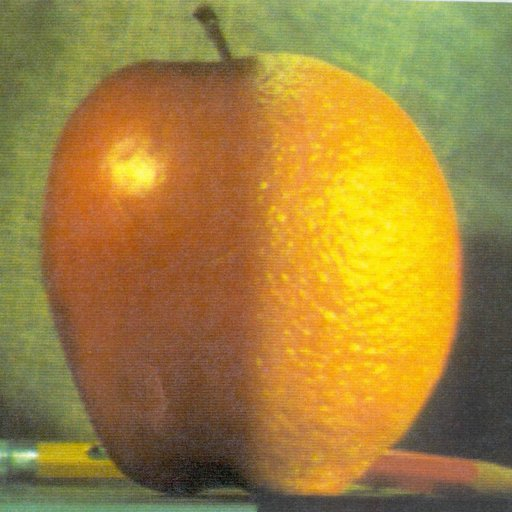
